# ML on ESDC using PyTorch 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library PyTorch. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs with the python environment deepesdl-ml-pytorch, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/).**

### Import necessary libraries

In [6]:
import math
import numpy as np
import mlflow
import xarray as xr
from xcube.core.store import new_data_store

import mltools as ml
import pandas as pd

import dask.array as da

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.nn.functional import normalize

from global_land_mask import globe
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import os


### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
ds = dataset[['land_surface_temperature', 'air_temperature_2m']]
ds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [9]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0 = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [10]:
lm = da.stack([lm0 for i in range(ds.dims['time'])], axis = 0)
lm

dask.array<stack, shape=(10, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [11]:
xdsm = ds.assign(land_mask= (['time','lat','lon'],lm.rechunk(chunks=([v for k,v in ml.get_chunk_sizes(ds)]))))
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube to a pandas dataframe.

In [9]:
df = xdsm.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature   
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN  \
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

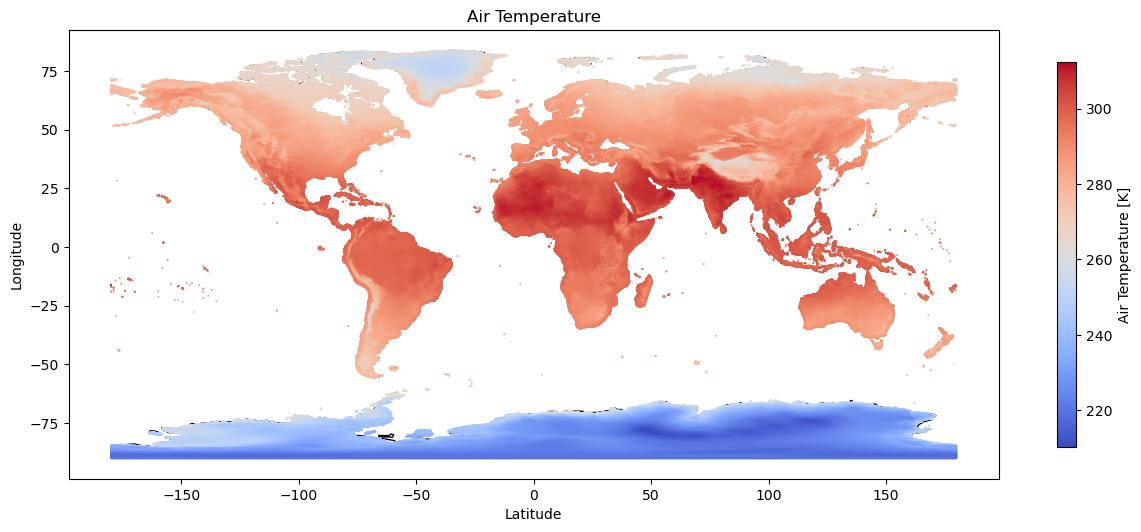

In [10]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'air_temperature_2m', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Air Temperature [K]'});

plt.title('Air Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#plt.savefig('air_temp_masked.png')

Land Surface Temperature

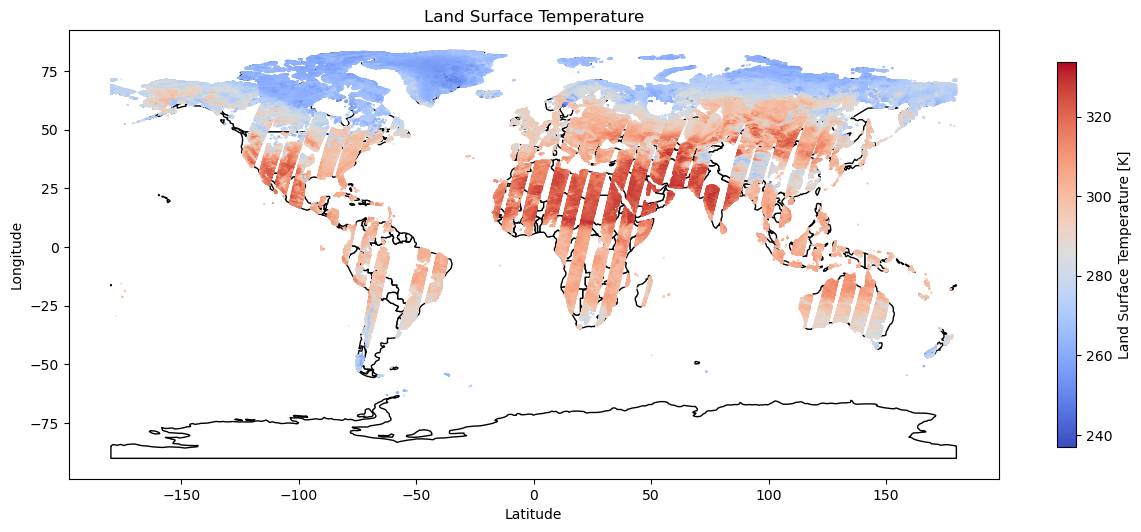

In [11]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Land Surface Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#plt.savefig('land_surface_temperature.png')

### Assign train/test split
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [12]:
# random sampling
#xds = xdsm.assign({"split": ml.rand})
#xds

# block sampling
xds = ml.assign_split(xdsm, block_size=[("time", 10), ("lat", 100), ("lon", 100)], split=0.8)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

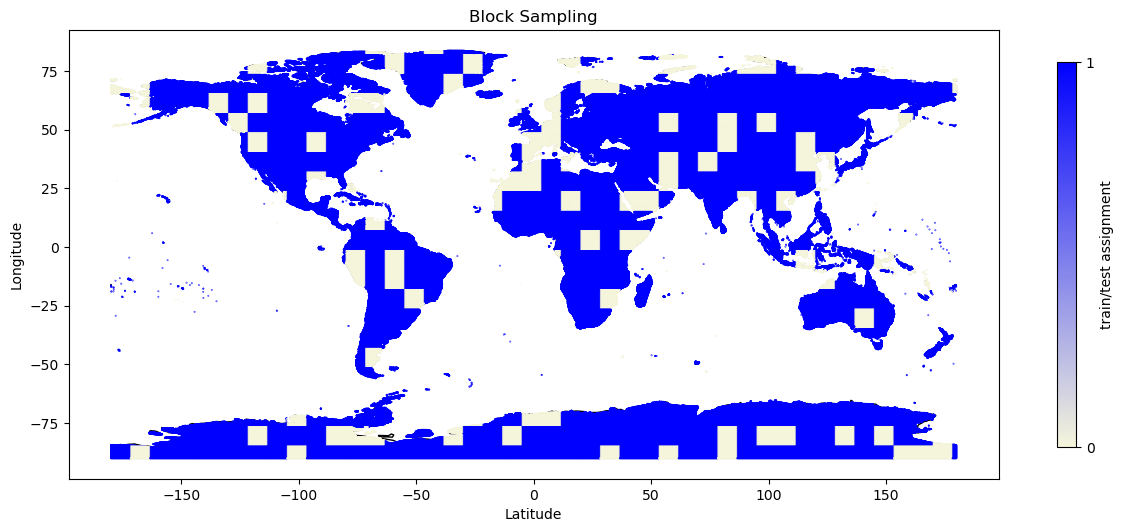

In [13]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'split', cmap = LinearSegmentedColormap.from_list("", ["beige","blue"]), legend = True, 
    legend_kwds={"shrink":.5, 'label': 'train/test assignment', 'ticks': [0,1]});

plt.title('Block Sampling');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
plt.savefig('train_test_assignment_bs.png')

### Model set up

Select cuda device if available to use GPU ressources

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### Initialize MLFlow experiment

In [8]:
experiment_name = "Pytorch Linear Regression of LST from AT with mlflow"
mlflow.set_experiment(experiment_name)

current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id = current_experiment['experiment_id']

run_name = "ESDC_LR_block_0.1"
mlflow.autolog()

2023/05/08 16:53:52 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/05/08 16:53:52 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


#### Define model, loss and optimizer

In [9]:
lr = 0.1
epochs = 3

reg_model = nn.Linear(in_features=1, out_features=1, bias=True)
mse_loss = nn.MSELoss()
optimizer = torch.optim.SGD(reg_model.parameters(), lr=lr)

Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [10]:
#at_range = ml.getRange(ds, 'air_temperature_2m')
#lst_range = ml.getRange(ds, 'land_surface_temperature')

at_stat = ml.getStatistics(ds, 'air_temperature_2m')
lst_stat = ml.getStatistics(ds, 'land_surface_temperature')

### Train model

We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [ ]:
with mlflow.start_run(experiment_id=experiment_id, run_name = run_name) as run:
    
    mlflow.log_param('lr', lr)
    mlflow.log_param('number_epochs', epochs)
    
    for chunk in ml.iter_data_var_blocks(xds): 
        ### preprocessing 
        # flatten
        cf = {x: chunk[x].ravel() for x in chunk.keys()}
        # choose land values
        lm = cf['land_mask']
        cft = {x: cf[x][lm == True] for x in cf.keys()}
        # drop nans
        lst = cft['land_surface_temperature']
        cfn = {x: cft[x][~np.isnan(lst)] for x in cf.keys()}

        if len(cfn['land_surface_temperature']) > 0:
            #X = normalize(cfn['air_temperature_2m'], 'air_temperature_2m')
            #y = normalize(cfn['land_surface_temperature'], 'land_surface_temperature')
            X = ml.standardize(cfn['air_temperature_2m'],*at_stat)
            y = ml.standardize(cfn['land_surface_temperature'], *lst_stat)

            ### get train/test data 
            X_train = X[cfn['split']==True]
            X_test  = X[cfn['split']==False]
            y_train = y[cfn['split']==True]
            y_test  = y[cfn['split']==False]

            if len(X_train) > 0:
                train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
                trainloader = DataLoader(train_ds, batch_size=50, shuffle=True)
                
            if len(X_test) > 0:
                test_ds  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
                testloader  = DataLoader(test_ds, batch_size=50, shuffle=True)

            ### train model 
            for i in range(1, epochs + 1):
                if len(X_train) > 0:
                    reg_model, train_pred,loss = ml.train_one_epoch(i, trainloader, reg_model, mse_loss, optimizer, device)
                    mlflow.log_metric('train_loss', loss)
                    print(f"Training Error: Avg loss: {loss:>8f}")
                if len(X_test) > 0:
                    test_pred, test_loss = ml.test(testloader, reg_model, mse_loss, device)
                    mlflow.log_metric('test_loss', test_loss)
                    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

Training Error: Avg loss: 0.000000
Test Error: Avg loss: 0.035184 

Training Error: Avg loss: 0.000000
Test Error: Avg loss: 0.034911 

Training Error: Avg loss: 0.000000
Test Error: Avg loss: 0.034558 

Training Error: Avg loss: 0.047752
Test Error: Avg loss: 0.024844 

Training Error: Avg loss: 0.047182
Test Error: Avg loss: 0.024669 

Training Error: Avg loss: 0.047923
Test Error: Avg loss: 0.025110 

Training Error: Avg loss: 0.031116
Test Error: Avg loss: 0.028106 

Training Error: Avg loss: 0.031623
Test Error: Avg loss: 0.028256 

Training Error: Avg loss: 0.031247
Test Error: Avg loss: 0.028708 

Training Error: Avg loss: 0.023246
Test Error: Avg loss: 0.017980 

Training Error: Avg loss: 0.023362
Test Error: Avg loss: 0.019131 

Training Error: Avg loss: 0.023840
Test Error: Avg loss: 0.019541 

Training Error: Avg loss: 0.028953
Test Error: Avg loss: 0.031281 

Training Error: Avg loss: 0.028662
Test Error: Avg loss: 0.031689 

Training Error: Avg loss: 0.028711
Test Error: A

### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [13]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  split  
lat        lon                                       
 89.958333 -179.958333 2002-05-21      False    0.0  
           -179.875000 2002-05-21      False    0.0  
           -179.791667 2002-05-21      False    0.0  
           -179.708333 2002-05-21      False    0.0  
           -179.625000 2002-05-21      False    0.0  
...                           ...        ...    ...  
-89.958333  179.625000 2002-05-21       True    1.0  
            179.708333 2002-05-21       True    1.0  
            179.791667 2002-05-21       True    1.0  
            179.875000 2002-05-21       True    1.0  
            179.958333 2002-05-21       True    1.0  

[9331200 rows x 5 columns]

Predict missing Land Surface Temperature values from Air Temperature values

In [13]:
dfl = df[df['land_mask'] == True]
orig = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output = to_pred.drop('land_surface_temperature', axis = 1)

X = ml.standardize(to_pred['air_temperature_2m'], *at_stat)
X = X.values

lstp = reg_model(torch.tensor(X.reshape(-1, 1)).to(device))
output['land_surface_temperature'] = ml.undo_standardizing(lstp.detach().cpu().numpy(), *lst_stat)
output

air_temperature_2m       time  land_mask  split   
lat        lon                                                            
 83.208333 -73.958333           266.152954 2002-05-21       True    1.0  \
 83.125000 -77.041667           265.867096 2002-05-21       True    1.0   
           -76.958333           265.832367 2002-05-21       True    1.0   
           -76.875000           265.832367 2002-05-21       True    1.0   
           -76.791667           265.832367 2002-05-21       True    1.0   
...                                    ...        ...        ...    ...   
-89.958333  179.625000          219.817398 2002-05-21       True    1.0   
            179.708333          219.817398 2002-05-21       True    1.0   
            179.791667          219.817398 2002-05-21       True    1.0   
            179.875000          219.817398 2002-05-21       True    1.0   
            179.958333          219.817398 2002-05-21       True    1.0   

                        land_surface_temperature  
lat        lon                                    
 83.208333 -73.958333                 267.022308  
 83.125000 -77.041667                 266.733765  
           -76.958333                 266.698700  
           -76.875000                 266.698700  
           -76.791667                 266.698700  
...                                          ...  
-89.958333  179.625000                220.250519  
            179.708333                220.250519  
            179.791667                220.250519  
            179.875000                220.250519  
            179.958333                220.250519  

[1739067 rows x 5 columns]

### Plot Predictions

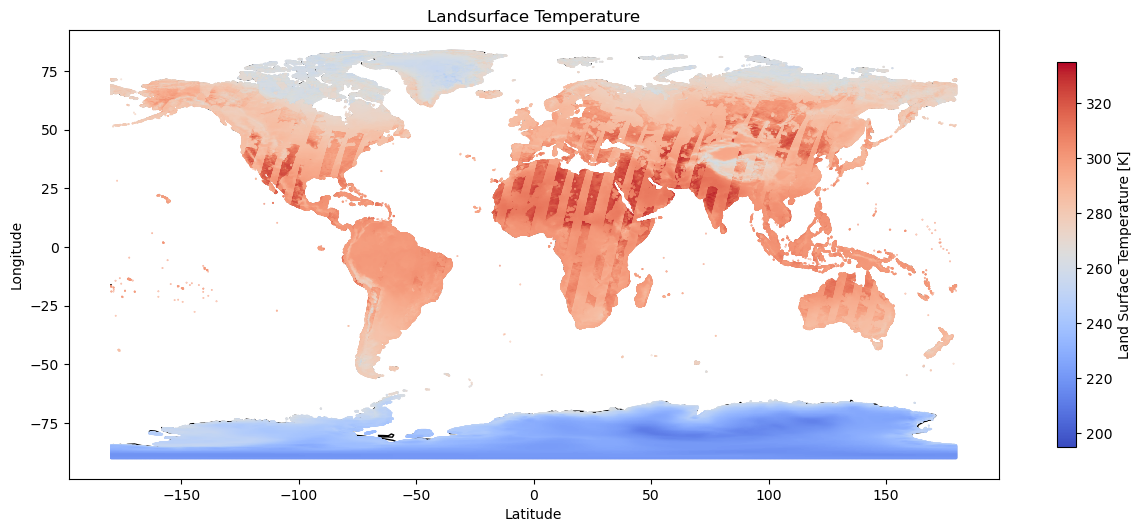

In [14]:

df = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

geometry = [Point(xy) for xy in zip(lst['lon'], lst['lat'])]
gdf = GeoDataFrame(lst, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'land_surface_temperature', cmap = 'coolwarm',  vmin = 195, vmax = 335, legend = True, 
    legend_kwds={"shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Landsurface Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#fname = 'xxx' +'.png'
#plt.savefig(fname)
plt.show()

### Launch MLFlow UI

You can start the MLflow UI within your DeepESDL-Hub JupyterLab session from terminal via
> `mlflow server --port 80 --backend-store-uri $MLFLOW_TRACKING_URI --default-artifact-root $MLFLOW_DEFAULT_ARTIFACT_ROOT`
and open it via
> `echo https://deep.earthsystemdatalab.net/user/$JUPYTERHUB_USER/proxy/80/`
Note: if configured for your team within DeepESDL-Hub you can also directly navigate to the persistent deployment of your MLflow serve via
> `echo $MLFLOW_UI_TEAM_URL`

In [ ]:
!mlflow ui 
#jupyterhub: visit https://mlflow-8a63c7.deep.earthsystemdatalab.net/
#this can be done in terminal simultaneously to calculating epochs

### Save prediction as cube in s3-store

In [12]:
# select time slices (start, end)
ts = xds.sel(time=slice('2002-05-21', '2002-07-24'))
ts

<xarray.Dataset>
Dimensions:                   (time: 9, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-07-24
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(9, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(9, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(9, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(9, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Calculate predictions

In [13]:
df = ts.to_dataframe()
dfl = df[df['land_mask'] == True]
orig = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output = to_pred.drop('land_surface_temperature', axis = 1)

X = ml.standardize(to_pred['air_temperature_2m'], *at_stat)
X = X.values

lstp = reg_model(torch.tensor(X.reshape(-1, 1)).to(device))
output['land_surface_temperature'] = ml.undo_standardizing(lstp.detach().cpu().numpy(), *lst_stat)
output

air_temperature_2m  land_mask  split  \
time       lat        lon                                                 
2002-05-21  83.208333 -73.958333           266.152954       True    1.0   
            83.125000 -77.041667           265.867096       True    1.0   
                      -76.958333           265.832367       True    1.0   
                      -76.875000           265.832367       True    1.0   
                      -76.791667           265.832367       True    1.0   
...                                               ...        ...    ...   
2002-07-24 -89.958333  179.625000          220.299347       True    1.0   
                       179.708333          220.299347       True    1.0   
                       179.791667          220.299347       True    1.0   
                       179.875000          220.299347       True    1.0   
                       179.958333          220.299347       True    1.0   

                                   land_surface_temperature  
time       lat        lon                                    
2002-05-21  83.208333 -73.958333                 267.022156  
            83.125000 -77.041667                 266.733582  
                      -76.958333                 266.698517  
                      -76.875000                 266.698517  
                      -76.791667                 266.698517  
...                                                     ...  
2002-07-24 -89.958333  179.625000                220.733810  
                       179.708333                220.733810  
                       179.791667                220.733810  
                       179.875000                220.733810  
                       179.958333                220.733810  

[15015594 rows x 4 columns]

In [14]:
dfp = pd.concat([orig, output])


In [ ]:
xar = dfp.to_xarray()

Set metadata

In [ ]:
xar.attrs['date_created'] = '08.05.2023'
xar.attrs['source'] = 'Earth System Data Cube'
xar.attrs['project'] = 'ESA DeepESDL'
xar.attrs['title'] = 'Predicted land surface temperature'
xar.attrs['summary'] = 'Missing land surface temperature values predicted from air temperature values by linear regression'

xar.land_surface_temperature.attrs['unit'] = 'K'
xar.air_temperature_2m.attrs['unit'] = 'K'

In [ ]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

In [ ]:
from xcube.core.store import new_data_store
team_store = new_data_store("s3", 
                       root=S3_USER_STORAGE_BUCKET, 
                       storage_options=dict(anon=False, 
                                            key=S3_USER_STORAGE_KEY, 
                                            secret=S3_USER_STORAGE_SECRET))

In [ ]:
team_store.write_data(xar,'Predicted_LST.zarr', replace=True)
